# 0. 필요 데이터 설치

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt

In [62]:
# 1. 산불위험예보 목록정보 전처리 (2021~2024년)
df_risk = pd.read_csv('산림청 국립산림과학원_대형산불위험예보목록정보_20250430.csv', encoding='euc-kr')
df_risk = df_risk.rename(columns={
    '예보일시': 'date', '시도명': 'province', '시군구명': 'city',
    '실효습도': 'effective_humidity', '풍속': 'wind_speed', '등급': 'risk_grade'
})
df_risk['date_dt'] = pd.to_datetime(df_risk['date'], errors='coerce').dt.date
df_risk = df_risk[
    (df_risk['date_dt'] >= pd.to_datetime('2021-01-01').date()) &
    (df_risk['date_dt'] <= pd.to_datetime('2024-12-31').date())
]

In [63]:
# 2. 산불 발생 데이터 전처리 (2021~2024년)
df_fire = pd.read_csv('sanbul.csv', encoding='cp949')
df_fire['date_dt'] = pd.to_datetime(df_fire['발생일시'], errors='coerce').dt.date
df_fire = df_fire.rename(columns={'시도명': 'province', '시군구명': 'city'})
df_fire = df_fire[
    (df_fire['date_dt'] >= datetime(2021,1,1).date()) &
    (df_fire['date_dt'] <= datetime(2024,12,31).date())
]

In [64]:
# 3. 산불 발생 그룹화 및 발생 여부 생성
fire_group = df_fire.groupby(['date_dt', 'province', 'city']).size().reset_index(name='fire_count')
fire_group['fire_occurred'] = 1

In [65]:
# 4. 위험예보+산불데이터 병합 (날짜+지역 기준)
df = pd.merge(df_risk, fire_group[['date_dt', 'province', 'city', 'fire_occurred']], 
              on=['date_dt', 'province', 'city'], how='left')
df['fire_occurred'] = df['fire_occurred'].fillna(0).astype(int)

In [66]:
# 5. 고급 피처 엔지니어링
df['risk_grade_num'] = df['risk_grade'].map({'주의보': 2, '경보': 3, '기타': 1})
df['month'] = pd.to_datetime(df['date_dt']).dt.month
df['season'] = df['month'].map({12:0,1:0,2:0,3:1,4:1,5:1,6:2,7:2,8:2,9:3,10:3,11:3})
df['dayofyear'] = pd.to_datetime(df['date_dt']).dt.dayofyear

# 상호작용 피처 추가
df['humidity_wind_interaction'] = df['effective_humidity'] * df['wind_speed']
df['risk_wind_interaction'] = df['risk_grade_num'] * df['wind_speed']
df['humidity_season_interaction'] = df['effective_humidity'] * df['season']

features = ['effective_humidity', 'wind_speed', 'risk_grade_num', 'month', 'season', 
           'dayofyear', 'humidity_wind_interaction', 'risk_wind_interaction', 'humidity_season_interaction']
df = df.dropna(subset=features)

In [67]:
# 6. 다양한 오버샘플링 기법 비교
X = df[features].astype(float)
y = df['fire_occurred']

# 정규화 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

minority_count = sum(y == 1)
sampling_methods = {}

if minority_count >= 6:
    try:
        smote = SMOTE(random_state=42, k_neighbors=min(5, minority_count-1))
        X_smote, y_smote = smote.fit_resample(X_scaled, y)
        sampling_methods['SMOTE'] = (X_smote, y_smote)
        
        adasyn = ADASYN(random_state=42, n_neighbors=min(5, minority_count-1))
        X_adasyn, y_adasyn = adasyn.fit_resample(X_scaled, y)
        sampling_methods['ADASYN'] = (X_adasyn, y_adasyn)
        
        smoteenn = SMOTEENN(random_state=42)
        X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_scaled, y)
        sampling_methods['SMOTEENN'] = (X_smoteenn, y_smoteenn)
        
    except Exception as e:
        print(f"오버샘플링 오류: {e}")
        sampling_methods['Original'] = (X_scaled, y)
else:
    sampling_methods['Original'] = (X_scaled, y)

# 최적 샘플링 방법 선택 (교차검증)
best_sampling = 'Original'
best_score = 0

for method_name, (X_sample, y_sample) in sampling_methods.items():
    if len(X_sample) > 0:
        try:
            xgb_temp = XGBClassifier(random_state=42, eval_metric='logloss')
            cv_scores = cross_val_score(xgb_temp, X_sample, y_sample, cv=3, scoring='f1')
            avg_score = np.mean(cv_scores)
            print(f"{method_name} CV F1 Score: {avg_score:.4f}")
            
            if avg_score > best_score:
                best_score = avg_score
                best_sampling = method_name
        except:
            continue

print(f"최적 샘플링 방법: {best_sampling}")
X_resampled, y_resampled = sampling_methods[best_sampling]

SMOTE CV F1 Score: 0.8304
ADASYN CV F1 Score: 0.7236
SMOTEENN CV F1 Score: 0.8625
최적 샘플링 방법: SMOTEENN


In [68]:
# 7. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [69]:
# 8. 고급 앙상블 (스태킹) + 하이퍼파라미터 튜닝
# 베이스 모델들
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
rf_model = RandomForestClassifier(random_state=42)
lgb_model = LGBMClassifier(random_state=42, verbose=-1)

# 하이퍼파라미터 튜닝
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, (y_resampled == 0).sum() / max((y_resampled == 1).sum(), 1)]
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5]
}

lgb_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

# GridSearch로 최적 파라미터 탐색
cv_folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("XGBoost 하이퍼파라미터 튜닝...")
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=cv_folds, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

print("RandomForest 하이퍼파라미터 튜닝...")
rf_grid = GridSearchCV(rf_model, rf_params, cv=cv_folds, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print("LightGBM 하이퍼파라미터 튜닝...")
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=cv_folds, scoring='f1', n_jobs=-1)
lgb_grid.fit(X_train, y_train)
best_lgb = lgb_grid.best_estimator_

# 스태킹 앙상블
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('rf', best_rf),
        ('lgb', best_lgb)
    ],
    final_estimator=LogisticRegression(random_state=42),
    cv=3,
    stack_method='predict_proba'
)

# 확률 보정 적용
calibrated_clf = CalibratedClassifierCV(stacking_clf, method='sigmoid', cv=3)
calibrated_clf.fit(X_train, y_train)

XGBoost 하이퍼파라미터 튜닝...
RandomForest 하이퍼파라미터 튜닝...
LightGBM 하이퍼파라미터 튜닝...


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWa

CalibratedClassifierCV(cv=3,
                       estimator=StackingClassifier(cv=3,
                                                    estimators=[('xgb',
                                                                 XGBClassifier(base_score=None,
                                                                               booster=None,
                                                                               callbacks=None,
                                                                               colsample_bylevel=None,
                                                                               colsample_bynode=None,
                                                                               colsample_bytree=None,
                                                                               device=None,
                                                                               early_stopping_rounds=None,
                                                                               enable_categorical=False,
                                                                               eval_metric='logloss',
                                                                               feature_types=None,
                                                                               feature_weights=None,
                                                                               gamma=None,
                                                                               grow_po...
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               multi_strategy=None,
                                                                               n_estimators=200,
                                                                               n_jobs=None,
                                                                               num_parallel_tree=None, ...)),
                                                                ('rf',
                                                                 RandomForestClassifier(max_depth=10,
                                                                                        n_estimators=200,
                                                                                        random_state=42)),
                                                                ('lgb',
                                                                 LGBMClassifier(max_depth=7,
                                                                                n_estimators=200,
                                                                                random_state=42,
                                                                                verbose=-1))],
                                                    final_estimator=LogisticRegression(random_state=42),
                                                    stack_method='predict_proba'))

In [70]:
# 9. 임계값 자동 최적화
probs = calibrated_clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# F1-score가 최대인 임계값 찾기
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"최적 임계값: {best_threshold:.4f} (F1-score: {best_f1:.4f})")

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


최적 임계값: 0.5149 (F1-score: 0.9896)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [71]:
# 10. 최적 임계값으로 평가
preds = (probs > best_threshold).astype(int)
print(f"\n[최적 임계값 {best_threshold:.4f}] 분류 리포트:")
print(classification_report(y_test, preds, zero_division=0))
print(f"[최적 임계값 {best_threshold:.4f}] 혼동 행렬:")
print(confusion_matrix(y_test, preds))
print(f"정확도: {accuracy_score(y_test, preds):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, probs):.4f}")


[최적 임계값 0.5149] 분류 리포트:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3067
           1       0.99      0.99      0.99      3022

    accuracy                           0.99      6089
   macro avg       0.99      0.99      0.99      6089
weighted avg       0.99      0.99      0.99      6089

[최적 임계값 0.5149] 혼동 행렬:
[[3032   35]
 [  29 2993]]
정확도: 0.9895
Average Precision Score: 0.9991


C:\Users\User\AppData\Local\Temp\ipykernel_23916\2167705694.py:25: UserWarning: Glyph 44257 (\N{HANGUL SYLLABLE GOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_23916\2167705694.py:25: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_23916\2167705694.py:25: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_23916\2167705694.py:25: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_23916\2167705694.py:25: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_23916\2167705694.py:25: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from f

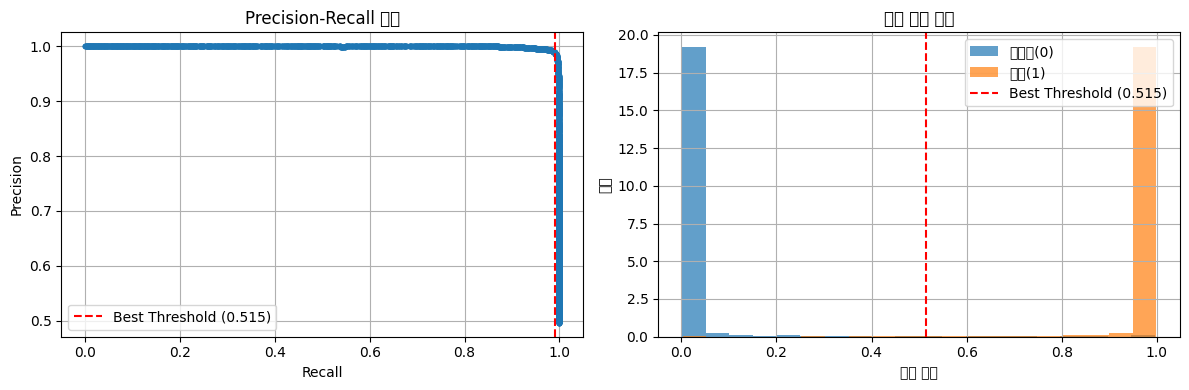

In [72]:
# 11. 시각화
plt.figure(figsize=(12, 4))

# Precision-Recall 곡선
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.')
plt.axvline(x=recall[best_threshold_idx], color='red', linestyle='--', 
            label=f'Best Threshold ({best_threshold:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall 곡선')
plt.legend()
plt.grid(True)

# 확률 분포
plt.subplot(1, 2, 2)
plt.hist(probs[y_test==0], bins=20, alpha=0.7, label='미발생(0)', density=True)
plt.hist(probs[y_test==1], bins=20, alpha=0.7, label='발생(1)', density=True)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.3f})')
plt.xlabel('예측 확률')
plt.ylabel('밀도')
plt.title('예측 확률 분포')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# 12. 예측 결과 샘플
print("\n예측 결과 샘플:")
result_sample = pd.DataFrame({
    'actual': y_test[:10], 
    'predicted': preds[:10], 
    'probability': probs[:10]
})
print(result_sample)


예측 결과 샘플:
       actual  predicted  probability
1949        0          0     0.002716
19242       1          1     0.996283
14400       0          0     0.002116
3676        0          0     0.002577
10582       0          0     0.007582
20954       1          1     0.991478
9153        0          0     0.002834
22761       1          1     0.996039
15246       0          0     0.002671
29596       1          1     0.995098


In [74]:
# 13. 모델 성능 요약
print(f"\n=== 최종 모델 성능 요약 ===")
print(f"샘플링 방법: {best_sampling}")
print(f"최적 임계값: {best_threshold:.4f}")
print(f"정확도: {accuracy_score(y_test, preds):.4f}")
print(f"F1-score: {f1_score(y_test, preds):.4f}")
print(f"Average Precision: {average_precision_score(y_test, probs):.4f}")


=== 최종 모델 성능 요약 ===
샘플링 방법: SMOTEENN
최적 임계값: 0.5149
정확도: 0.9895
F1-score: 0.9894
Average Precision: 0.9991


In [75]:
# 14. 모델 저장
import joblib
joblib.dump(calibrated_clf, 'advanced_fire_prediction_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
print("모델 저장 완료: advanced_fire_prediction_model.pkl")

모델 저장 완료: advanced_fire_prediction_model.pkl
